In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# RNN
import torch
import torch.nn as nn
import torch.optim as optim

# Evaluation (Metrics & DM-Test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import islice
from math import lgamma, fabs, isnan, nan, exp, log, log1p, sqrt
from typing import Sequence, Callable, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

#### **1. Data Preparation**

In [ ]:
df = pd.read_csv("df_ff_factors_010225.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')
df.columns

In [ ]:
# Generate Lagged Dataset
def create_lagged_dataset(dataset, lag, target_var, id):
    lagged_dataset = dataset.copy()
    columns_list = list(lagged_dataset.columns)
    data_join = {}
    for column in columns_list:
        if column == target_var:
            data_join[column] = lagged_dataset[column]
        for n in range(1,lag+1):
            data_join[F'{column}_L{n}'] = lagged_dataset.groupby(id)[column].shift(n)
    lagged_dataset = pd.concat(data_join.values(), axis=1, ignore_index = True)
    lagged_dataset.columns = data_join.keys()
    return lagged_dataset.dropna()

# Generate Stepped Dataset for Training
## Steps is the number of months ahead that we are forecasting, e.g. step=2 is 2 months ahead.
## Note step=1 results in no change to dataset, i.e. use generated lagged variables to forecast current. 
def create_stepped_dataset(dataset, step, target_var, id):
    
    shifted_dataset = dataset.copy()
    shifted_dataset['shifted_target'] = shifted_dataset.groupby(id)[target_var].shift(-step + 1)
    
    # Drop rows where the shifted target is NaN (these occur due to the shift operation)
    shifted_dataset = shifted_dataset.dropna(subset=['shifted_target'])
    
    # Separate the features (X) and the target (y)
    X = shifted_dataset.drop(columns=[target_var, 'shifted_target'])
    y = shifted_dataset[['shifted_target']]
    y = y.rename(columns={'shifted_target':target_var})
    return X, y

x = create_lagged_dataset(df, lag = 1, target_var='rolling_sharpe', id = 'crsp_fundno')
test_step = create_stepped_dataset(x, step=1, target_var='rolling_sharpe', id = 'crsp_fundno_L1')[1]
# test_step
corr = np.corrcoef(df['rolling_alpha_5f'], df['rolling_sharpe'])
# corr # 0.164 --> can use!

In [ ]:
def demeaning_fund_char(dataset, id, characteristic):
    for col in characteristic:
        dataset[f'demeaned_{col}'] = dataset[col] - dataset.groupby(id)[col].transform('mean')
    return dataset

char_to_demean = ["exp_ratio", "turn_ratio", "normalised_flow", "shortrun_momentum"]
df = demeaning_fund_char(df, id="crsp_fundno", characteristic = char_to_demean)
df = df.drop(columns = char_to_demean)   # drop original columns

In [ ]:
# Generates next date
def generate_next_date(list_of_dates, date):
    return list_of_dates[list_of_dates > date].min()


def process_factor_model(X_factor, y_factor, train_end, test_date):
    X_train = X_factor[X_factor['date_L1'] <= train_end].drop(columns='date_L1')
    X_test = X_factor[X_factor['date_L1'] == test_date].drop(columns='date_L1')

    y_train = y_factor.loc[X_train.index]
    y_test = y_factor.loc[X_test.index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


#### **2. Model Training (Sharpe Ratio)**

Asset-Pricing Factor Models:
* 3-Factor Model: mktrf, SMB, HML
* 4-Factor Model: mktrf, SMB, HML, UMD
* 5-Factor Model: mktrf, SMB, HML, RMW, CMA

The overall_function trains the models using the final selected parameters after hyperparameter tuning.

In [ ]:
# Training Cycle
def overall_function(dataset, outcome):
    dataset['date'] = pd.to_datetime(dataset['date']) # converting to date format
    dataset = dataset.sort_values(by='date')
    
    # Factor Models
    df_3_factor = dataset.drop(columns=['mkt_return','umd','cma','rmw','mth_return','rf','rolling_alpha_4f','rolling_alpha_5f'])
    df_4_factor = dataset.drop(columns=['mkt_return','cma','rmw','mth_return','rf','rolling_alpha_3f','rolling_alpha_5f'])
    df_5_factor = dataset.drop(columns=['mkt_return','umd','mth_return','rf','rolling_alpha_3f','rolling_alpha_4f'])
    
    # Creating Lagged and Stepped Datasets
    X_dataset_3f, y_dataset_3f = create_stepped_dataset(create_lagged_dataset(df_3_factor, lag=1,target_var=outcome, id = 'crsp_fundno'),step=1,target_var=outcome, id = 'crsp_fundno_L1')
    X_dataset_4f, y_dataset_4f = create_stepped_dataset(create_lagged_dataset(df_4_factor, lag=1,target_var=outcome, id = 'crsp_fundno'),step=1,target_var=outcome, id = 'crsp_fundno_L1')
    X_dataset_5f, y_dataset_5f = create_stepped_dataset(create_lagged_dataset(df_5_factor, lag=1,target_var=outcome, id = 'crsp_fundno'),step=1,target_var=outcome, id = 'crsp_fundno_L1')
    
    X_dataset_3f = X_dataset_3f.drop(columns=['crsp_fundno_L1'], errors='ignore')
    X_dataset_4f = X_dataset_4f.drop(columns=['crsp_fundno_L1'], errors='ignore')
    X_dataset_5f = X_dataset_5f.drop(columns=['crsp_fundno_L1'], errors='ignore')

    list_of_dates = pd.to_datetime(X_dataset_3f['date_L1'])
    percentile_70 = list_of_dates.quantile(0.7)
    train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
    df_end = list_of_dates.max()

    results = []
    
    while train_end != df_end:
        
        test_date = generate_next_date(list_of_dates, train_end)
        if pd.isna(test_date):
            break 

        # Process data for modeling
        X_train_3f, X_test_3f, y_train_3f, y_test_3f = process_factor_model(X_dataset_3f, y_dataset_3f, train_end, test_date)
        X_train_4f, X_test_4f, y_train_4f, y_test_4f = process_factor_model(X_dataset_4f, y_dataset_4f, train_end, test_date)
        X_train_5f, X_test_5f, y_train_5f, y_test_5f = process_factor_model(X_dataset_5f, y_dataset_5f, train_end, test_date)
        
        # For Adding Results
        df_in_loop = y_test_3f.copy()

        ### Model 1: Linear Regression ###
        linear = LinearRegression()
        linear.fit(X_train_3f, y_train_3f.values.ravel())
        linear3fpred = linear.predict(X_test_3f)
        linear.fit(X_train_4f, y_train_4f.values.ravel())
        linear4fpred = linear.predict(X_test_4f)
        linear.fit(X_train_5f, y_train_5f.values.ravel())
        linear5fpred = linear.predict(X_test_5f)
        
        print('Linear Regression 3-Factor Fitted')
        print('Linear Regression 4-Factor Fitted')
        print('Linear Regression 5-Factor Fitted')

        ## Adding Linear results
        df_in_loop['linear_3f'] = linear3fpred
        df_in_loop['linear_4f'] = linear4fpred
        df_in_loop['linear_5f'] = linear5fpred


        ### Model 2: Feedforward Neural Network ###
        model_3f = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200, learning_rate_init=0.01, learning_rate='constant', random_state=42)
        model_4f = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=200, learning_rate_init=0.01, learning_rate='constant', random_state=43)
        model_5f = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200, learning_rate_init=0.01, learning_rate='constant', random_state=44)
        
        model_3f.fit(X_train_3f, y_train_3f.values.ravel())
        print('FFNN 3-Factor Fitted')
        y_pred_3f = model_3f.predict(X_test_3f)
        
        model_4f.fit(X_train_4f, y_train_4f.values.ravel())
        print('FFNN 4-Factor Fitted')
        y_pred_4f = model_4f.predict(X_test_4f)
        
        model_5f.fit(X_train_5f, y_train_5f.values.ravel())
        print('FFNN 5-Factor Fitted')
        y_pred_5f = model_5f.predict(X_test_5f)

        # Adding FFNN results
        df_in_loop['ffnn_3f'] = y_pred_3f
        df_in_loop['ffnn_4f'] = y_pred_4f
        df_in_loop['ffnn_5f'] = y_pred_5f
        

        ### Model 3: Basic Recurrent Neural Network (RNN) ###
        ## 3-Factor RNN ##

        # Reshaping data
        X_train_3f_rnn = np.expand_dims(X_train_3f, axis=1)
        X_test_3f_rnn = np.expand_dims(X_test_3f, axis=1)
        
        ## Creating RNN
        rnn3fmodel = Sequential()
        rnn3fmodel.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_3f_rnn.shape[1], X_train_3f_rnn.shape[2])))
        rnn3fmodel.add(Dense(1))

        ## Using MSE as loss function
        rnn3fmodel.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        rnn3fmodel.fit(X_train_3f_rnn, y_train_3f.values, epochs=50, batch_size=32, verbose=0)
        rnn3fpred = rnn3fmodel.predict(X_test_3f_rnn).flatten()
        print('RNN 3-Factor Fitted')

        # 4-Factor RNN
        X_train_4f_rnn = np.expand_dims(X_train_4f, axis=1)
        X_test_4f_rnn = np.expand_dims(X_test_4f, axis=1)

        rnn4fmodel = Sequential()
        rnn4fmodel.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_4f_rnn.shape[1], X_train_4f_rnn.shape[2])))
        rnn4fmodel.add(Dense(1))

        rnn4fmodel.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        rnn4fmodel.fit(X_train_4f_rnn, y_train_4f.values, epochs=50, batch_size=32, verbose=0)
        rnn4fpred = rnn4fmodel.predict(X_test_4f_rnn).flatten()
        print('RNN 4-Factor Fitted')

        # 5-Factor RNN
        X_train_5f_rnn = np.expand_dims(X_train_5f, axis=1)
        X_test_5f_rnn = np.expand_dims(X_test_5f, axis=1)

        rnn5fmodel = Sequential()
        rnn5fmodel.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_5f_rnn.shape[1], X_train_5f_rnn.shape[2])))
        rnn5fmodel.add(Dense(1))

        rnn5fmodel.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        rnn5fmodel.fit(X_train_5f_rnn, y_train_5f.values, epochs=50, batch_size=32, verbose=0)
        rnn5fpred = rnn5fmodel.predict(X_test_5f_rnn).flatten()
        print('RNN 5-Factor Fitted')

        # Adding RNN results
        df_in_loop['3f_rnn'] = rnn3fpred
        df_in_loop['4f_rnn'] = rnn4fpred
        df_in_loop['5f_rnn'] = rnn5fpred
        

        ### Model 4: Random Forest Regression ###
        model = RandomForestRegressor(n_estimators=100, random_state=40, n_jobs=-1)

        model.fit(X_train_3f, y_train_3f.values.ravel())
        print('RF 3-Factor Fitted')
        y_pred_3f = model.predict(X_test_3f)

        model.fit(X_train_4f, y_train_4f.values.ravel())
        print('RF 4-Factor Fitted')
        y_pred_4f = model.predict(X_test_4f)

        model.fit(X_train_5f, y_train_5f.values.ravel())
        print('RF 5-Factor Fitted')
        y_pred_5f = model.predict(X_test_5f)

        df_in_loop['rf_3f'] = y_pred_3f
        df_in_loop['rf_4f'] = y_pred_4f
        df_in_loop['rf_5f'] = y_pred_5f
        

        # Add results into loop
        results.append(df_in_loop)
        train_end = test_date
        num_remaining_dates = len(list(set(date for date in list_of_dates if date > test_date)))
        print(f'{num_remaining_dates} dates remaining')
    
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df

In [ ]:
# Run to train the models
y = overall_function(dataset=df, outcome='rolling_sharpe')

# Save training results in .csv files
y.to_csv("results_sharpe/all_sharpe_ratio.csv", index=False)

##### **2.1 Hyperparameter Tuning (RNN)**

In [ ]:
# Ensure dataset date is properly formatted
df['date'] = pd.to_datetime(df['date'])
dataset = df.sort_values(by='date')

# Factor Models
df_3_factor = dataset.drop(columns=['mkt_return', 'umd', 'cma', 'rmw', 'mth_return', 'rf', 'rolling_alpha_4f', 'rolling_alpha_5f'])
df_4_factor = dataset.drop(columns=['mkt_return', 'cma', 'rmw', 'mth_return', 'rf', 'rolling_alpha_3f', 'rolling_alpha_5f'])
df_5_factor = dataset.drop(columns=['mkt_return', 'umd', 'mth_return', 'rf', 'rolling_alpha_3f', 'rolling_alpha_4f'])

# Creating Lagged and Stepped Datasets
X_dataset_3f, y_dataset_3f = create_stepped_dataset(create_lagged_dataset(df_3_factor, lag=1, target_var='rolling_sharpe', id='crsp_fundno'),
                                                     step=1, target_var='rolling_sharpe', id='crsp_fundno_L1')
X_dataset_4f, y_dataset_4f = create_stepped_dataset(create_lagged_dataset(df_4_factor, lag=1, target_var='rolling_sharpe', id='crsp_fundno'),
                                                     step=1, target_var='rolling_sharpe', id='crsp_fundno_L1')
X_dataset_5f, y_dataset_5f = create_stepped_dataset(create_lagged_dataset(df_5_factor, lag=1, target_var='rolling_sharpe', id='crsp_fundno'),
                                                     step=1, target_var='rolling_sharpe', id='crsp_fundno_L1')

# Remove unnecessary column
X_dataset_3f = X_dataset_3f.drop(columns=['crsp_fundno_L1'], errors='ignore')
X_dataset_4f = X_dataset_4f.drop(columns=['crsp_fundno_L1'], errors='ignore')
X_dataset_5f = X_dataset_5f.drop(columns=['crsp_fundno_L1'], errors='ignore')

# Splitting training and test sets based on date
list_of_dates = pd.to_datetime(X_dataset_5f['date_L1'])
percentile_70 = list_of_dates.quantile(0.7)
train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]

X_train = X_dataset_5f[X_dataset_5f['date_L1'] <= train_end].drop(columns='date_L1')
X_test = X_dataset_5f[X_dataset_5f['date_L1'] > train_end].drop(columns='date_L1')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_dataset_4f.loc[X_train.index]
y_test = y_dataset_4f.loc[X_test.index]

# Reshape input data for RNN (batch_size, sequence_length=1, num_features)
X_train_rnn = np.expand_dims(X_train_scaled, axis=1)
X_test_rnn = np.expand_dims(X_test_scaled, axis=1)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_rnn, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_test_tensor = torch.tensor(X_test_rnn, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader
batch_size = 32
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)  # Fully connected output layer

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])  # Take last time step output

# Hyperparameter Grid
neurons_num = [32, 64]  # Hidden units
epochs_list = [100, 200]  
optimizers = ['adam', 'sgd']
lr_list = [0.01, 0.005, 0.001]

# Track best model
best_mse = float("inf")
best_params = None

# Hyperparameter tuning loop
for optimizer_name in optimizers:
    for hidden_units in neurons_num:
        for epochs in epochs_list:
            for learning_r in lr_list:
                
                # Initialize model
                model = RNNModel(X_train_rnn.shape[2], hidden_units).to(device)
                criterion = nn.MSELoss()
                
                # Select optimizer
                if optimizer_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=learning_r)
                else:
                    optimizer = optim.SGD(model.parameters(), lr=learning_r)
                
                # Training Loop
                model.train()
                for epoch in range(epochs):
                    for batch_X, batch_y in dataloader_train:
                        optimizer.zero_grad()
                        output = model(batch_X)  # Forward pass
                        loss = criterion(output.squeeze(), batch_y.squeeze())  # Compute loss
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Update weights

                # Evaluation
                model.eval()
                with torch.no_grad():
                    y_pred_rnn = model(X_test_tensor).cpu().numpy().flatten()
                mse = mean_squared_error(y_test, y_pred_rnn)

                # Print results
                print(f'Optimizer: {optimizer_name}, Hidden Units: {hidden_units}, '
                      f'Epochs: {epochs}, Learning Rate: {learning_r}, MSE: {mse}')
                
                # Save best model
                if mse < best_mse:
                    best_mse = mse
                    best_params = {
                        'optimizer': optimizer_name,
                        'hidden_units': hidden_units,
                        'epochs': epochs,
                        'learning_rate': learning_r
                    }

print(f'Best Model: {best_params}, Best MSE: {best_mse}')

## best optimizer': 'sgd', 'hidden_units': 64, 'epochs': 100, 'learning_rate': 0.001}, Best MSE: 0.4382682578296826


#### **3. Diebold-Mariano (DM) Test for Sharpe Ratio**

In [ ]:
all_sharpe_ratio = pd.read_csv("results_sharpe/all_sharpe_ratio.csv")
all_sharpe_ratio = all_sharpe_ratio.drop(columns=["Unnamed: 0"], errors="ignore")

In [18]:
# Exception classes
class InvalidParameterException(Exception):
    def __init__(self, message: str):
        super().__init__(message)

class ZeroVarianceException(ArithmeticError):
    def __init__(self, message: str):
        super().__init__(message)

def autocovariance(X: Sequence[float], k: int, mean: float) -> float:
    """
    Returns the k-lagged autocovariance for the input iterable.
    """
    return sum((a - mean) * (b - mean) for a, b in zip(islice(X, k, None), X)) / len(X)

def log_beta(a: float, b: float) -> float:
    """
    Returns the natural logarithm of the beta function computed on arguments `a` and `b`.
    """
    return lgamma(a) + lgamma(b) - lgamma(a + b)

def evaluate_pvalue(pvalue: float) -> int:
    """
    Evaluates the p-value to determine model equivalence.
    - Returns -1 if p-value < 0.05 (statistically similar)
    - Returns 1 if p-value ≥ 0.05 (statistically different)
    - Returns 0 for self-comparisons
    """
    return -1 if pvalue < 0.05 else 1

def dm_test(
    V: Sequence[float],
    P1: Sequence[float],
    P2: Sequence[float],
    *,
    loss: Callable[[float, float], float] = lambda u, v: (u - v) ** 2,
    h: int = 1,
    one_sided: bool = False,
    harvey_correction: bool = True
) -> Tuple[float, float]:
    """
    Performs the Diebold-Mariano test. The null hypothesis is that the two forecasts (P1, P2)
    have equal predictive accuracy.
    """
    d = np.array([loss(V[i], P1[i]) - loss(V[i], P2[i]) for i in range(len(V))])
    mean_d = np.mean(d)

    gamma = np.array([np.cov(d[:-i], d[i:])[0, 1] if i > 0 else np.var(d, ddof=1) for i in range(h)])

    var_d = (gamma[0] + 2 * np.sum(gamma[1:])) / len(d)

    if var_d == 0:
        raise ZeroVarianceException("Variance of the DM statistic is zero. The prediction series might be identical.")

    dm_stat = mean_d / np.sqrt(var_d)

    n = len(d)
    if harvey_correction:
        harvey_adj = np.sqrt((n + 1 - 2 * h + h * (h - 1) / n) / n)
        dm_stat *= harvey_adj

    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=n-1)) if not one_sided else (1 - t.cdf(dm_stat, df=n-1))

    return dm_stat, p_value

def generate_dm_test_matrix(results_df: pd.DataFrame, outcome_var: str, forecast_vars: List[str]
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generates a pairwise DM test statistic and p-value matrix from your results DataFrame.
    """
    dm_stat_df = pd.DataFrame(index=forecast_vars, columns=forecast_vars)
    pvalue_df = pd.DataFrame(index=forecast_vars, columns=forecast_vars)
    
    for f1 in forecast_vars:
        for f2 in forecast_vars:
            if f1 == f2:
                dm_stat_df.loc[f1, f2] = 0
                pvalue_df.loc[f1, f2] = 0  
            else:
                try:
                    dmstat, pvalue = dm_test(
                        V=results_df[outcome_var].dropna().values,
                        P1=results_df[f1].dropna().reindex(results_df[outcome_var].dropna().index).values,
                        P2=results_df[f2].dropna().reindex(results_df[outcome_var].dropna().index).values,
                        one_sided=True
                    )
                    dm_stat_df.loc[f1, f2] = dmstat
                    pvalue_df.loc[f1, f2] = evaluate_pvalue(pvalue) 
                except Exception as e:
                    dm_stat_df.loc[f1, f2] = None
                    pvalue_df.loc[f1, f2] = None
    return dm_stat_df, pvalue_df

# **Run the DM test**
outcome_var = 'rolling_sharpe'
forecast_vars = ['linear_3f', 'linear_4f', 'linear_5f',
                 'ffnn_3f', 'ffnn_4f', 'ffnn_5f',
                 'rf_3f', 'rf_4f', 'rf_5f',
                 '3f_rnn', '4f_rnn', '5f_rnn']

dm_stat_df, dm_pvalue_df = generate_dm_test_matrix(all_sharpe_ratio, outcome_var, forecast_vars)

print("DM Test Statistics:")
print(dm_stat_df)
print("\nDM Test P-values:")
print(dm_pvalue_df)


DM Test Statistics:
           linear_3f  linear_4f  linear_5f    ffnn_3f    ffnn_4f    ffnn_5f  \
linear_3f          0  11.103139  -7.112878  -7.877305   -2.35463  -4.369037   
linear_4f -11.103139          0 -11.337693  -8.623697  -2.926115  -5.044291   
linear_5f   7.112878  11.337693          0  -6.932985   -1.64024  -3.535877   
ffnn_3f     7.877305   8.623697   6.932985          0   5.169606   4.297103   
ffnn_4f      2.35463   2.926115    1.64024  -5.169606          0  -2.082019   
ffnn_5f     4.369037   5.044291   3.535877  -4.297103   2.082019          0   
rf_3f     -17.569398 -16.967025 -18.136071 -35.050088 -21.281138 -28.556514   
rf_4f     -17.980132 -17.357693 -18.542213 -35.936856 -21.832694 -28.807258   
rf_5f     -17.720426  -17.12874 -18.289386 -33.907279 -21.067402 -30.007079   
3f_rnn    -22.003757 -21.368864 -22.706974 -35.059446 -18.404856 -27.844668   
4f_rnn    -19.002424 -18.275133 -19.736726 -29.627617 -15.814558 -22.924952   
5f_rnn    -11.976158 -11.129816 

##### **Heatmap for DM Test**

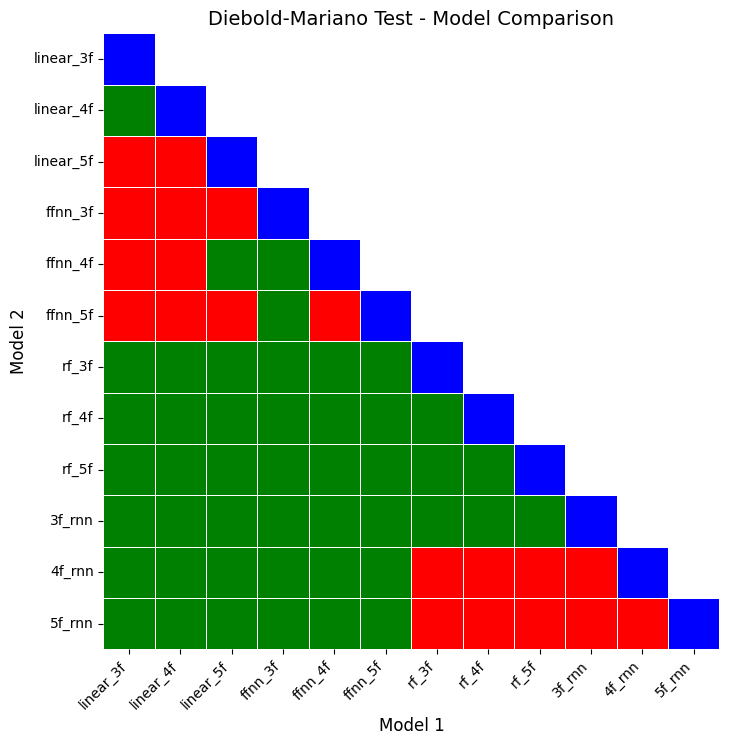

In [19]:
def plot_dm_test_results(p_value_df, title="Diebold-Mariano Test Results"):
    """
    Plots a triangular heatmap for the Diebold-Mariano test results.
    - Red (-1): Models are statistically similar (p-value < 0.05)
    - Green (1): Models are statistically different (p-value ≥ 0.05)
    - Blue (0): Self-comparisons (diagonal)
    """
    matrix = p_value_df.to_numpy().astype(float)

    # Define the mask to only show the lower triangle (excluding diagonal)
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)

    # Define the custom color map
    cmap = sns.color_palette(["red", "blue", "green"])  # Red (-1), Blue (0), Green (1)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix, mask=mask, cmap=cmap, annot=False, xticklabels=p_value_df.columns, yticklabels=p_value_df.index,
                cbar=False, linewidths=0.5, square=True)

    plt.title(title, fontsize=14)
    plt.xlabel("Model 1", fontsize=12)
    plt.ylabel("Model 2", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

# **Run and plot the results**
plot_dm_test_results(dm_pvalue_df, title="Diebold-Mariano Test - Model Comparison")
